## библиотеки

In [32]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import inv_boxcox  # Импорт функции для обратного преобразования
# plotting
import matplotlib.pyplot as plt
from scipy.stats import probplot
from statsmodels.graphics.gofplots import qqplot
## make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
# Добавление праздников США
from prophet.make_holidays import make_holidays_df
from pmdarima import auto_arima

## Функции

In [2]:

def plot_results(y_to_train,
                 y_to_test, y_forecast,
                 plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')

    if plot_conf_int:
        plt.fill_between(y_to_test.index,
                         left_bound, right_bound,
                         alpha=0.23, color='grey',
                         label='intervals')
    plt.legend()
    plt.show()


# 3. Метрики
# Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.
# MAPE
def mean_absolute_percentage_error(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    

def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }

    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table


## Prophet, SARIMAX, TBATS — модели для предсказания временных рядов

## 2. Данные

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с Kaggle с соревнования по прогнозированию спроса на товары.

In [3]:
data = pd.read_csv('data/train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
store, item = 1,1
data = data[(data['store'] == store) & (data['item'] == item)]
data = data.set_index('date')
data = data['sales']

In [5]:
data

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 1826, dtype: int64


Разделим данные на train и test. test — данные за последний год.

In [6]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем данные.

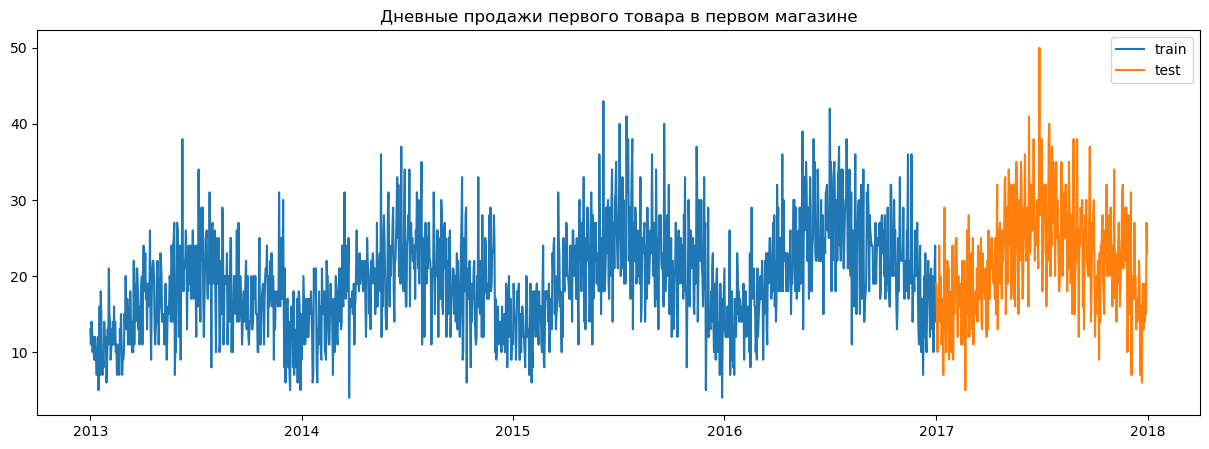

In [7]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')

plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend()

Некоторая недельная сезонность есть.

### 3. Метрики
Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.

Формула для вычисления метрики **MAPE**:

![image.png](attachment:image.png)

## Prophet

Prophet — модель, разработанная Facebook (запрещён на территории РФ) для предсказания временных рядов.

In [8]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [9]:
prophet_train_df

,y,ds
date,,
2013-01-01,13,2013-01-01
2013-01-02,11,2013-01-02
2013-01-03,14,2013-01-03
2013-01-04,13,2013-01-04
2013-01-05,10,2013-01-05
...,...,...
2016-12-27,10,2016-12-27
2016-12-28,16,2016-12-28
2016-12-29,21,2016-12-29


In [10]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.655334,12.783433,29.447390,22.655334,22.655334,-1.504652,-1.504652,-1.504652,3.723695,3.723695,3.723695,-5.228347,-5.228347,-5.228347,0.0,0.0,0.0,21.150682
1,2017-01-02,22.659383,4.820196,21.212661,22.659383,22.659383,-9.438402,-9.438402,-9.438402,-4.232830,-4.232830,-4.232830,-5.205571,-5.205571,-5.205571,0.0,0.0,0.0,13.220981
2,2017-01-03,22.663432,7.675976,24.718304,22.663421,22.663432,-6.835870,-6.835870,-6.835870,-1.635981,-1.635981,-1.635981,-5.199889,-5.199889,-5.199889,0.0,0.0,0.0,15.827562
3,2017-01-04,22.667480,7.943721,24.254007,22.667440,22.667494,-6.324686,-6.324686,-6.324686,-1.114474,-1.114474,-1.114474,-5.210212,-5.210212,-5.210212,0.0,0.0,0.0,16.342794
4,2017-01-05,22.671529,8.081546,24.469931,22.671471,22.671565,-5.942753,-5.942753,-5.942753,-0.707771,-0.707771,-0.707771,-5.234982,-5.234982,-5.234982,0.0,0.0,0.0,16.728776


Модель для каждой даты раскладывает своё предсказание на компоненты.

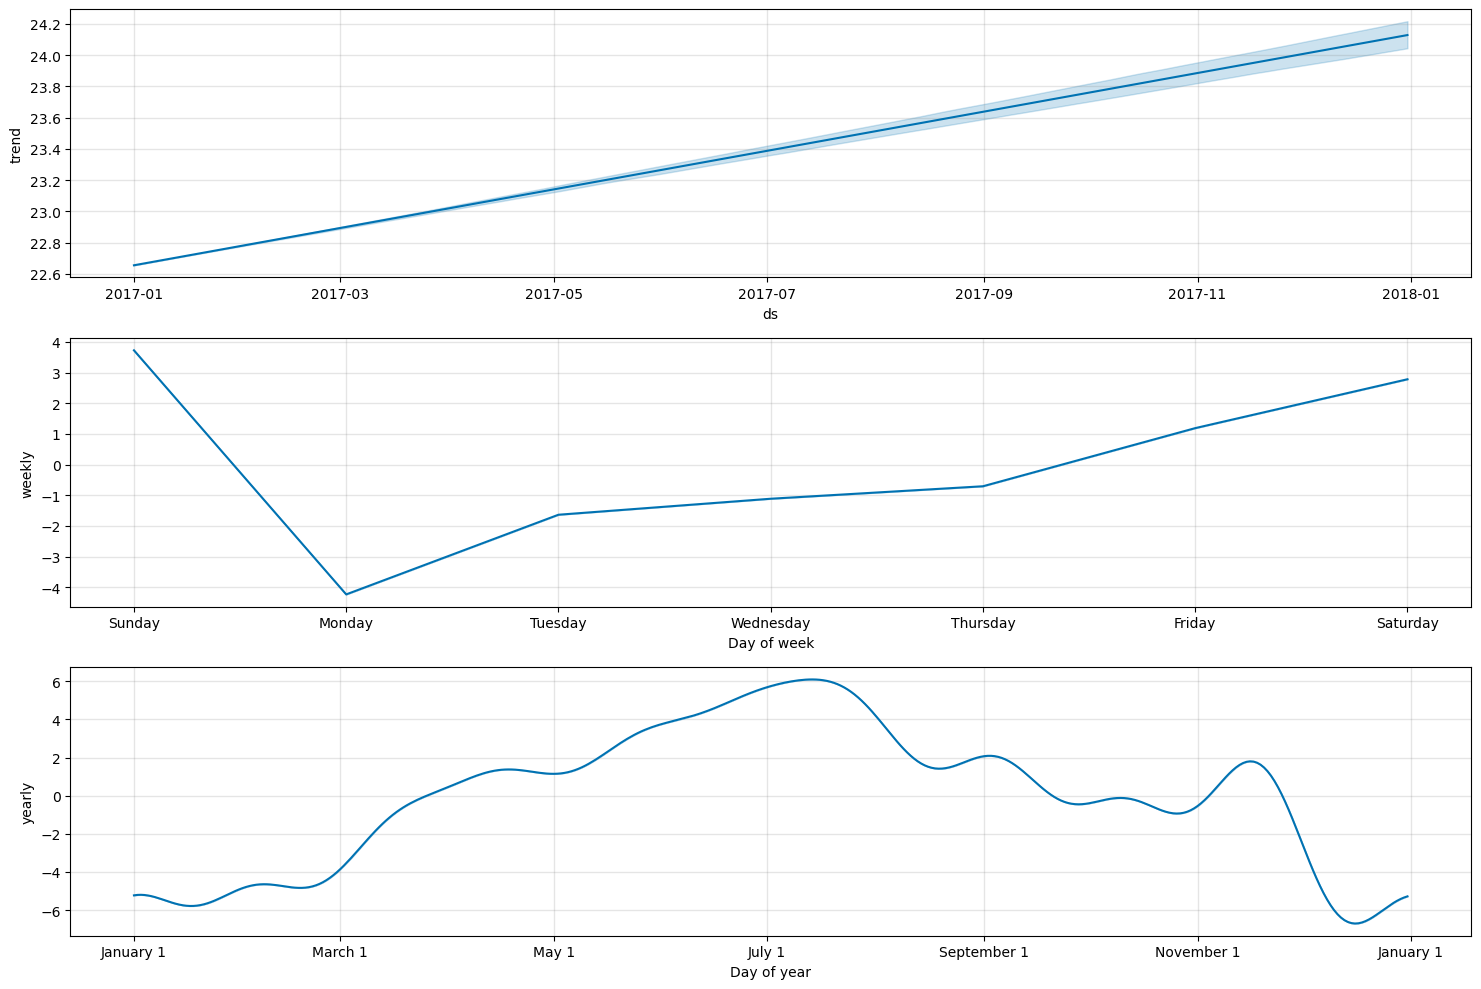

In [12]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10)) # Модель для каждой даты раскладывает своё предсказание на компоненты.
plt.show()

             y         ds
date                     
2013-01-01  13 2013-01-01
2013-01-02  11 2013-01-02
2013-01-03  14 2013-01-03
2013-01-04  13 2013-01-04
2013-01-05  10 2013-01-05


15:12:07 - cmdstanpy - INFO - Chain [1] start processing
15:12:07 - cmdstanpy - INFO - Chain [1] done processing


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-01-01  22.655334   12.256930   29.365304    22.655334    22.655334   
1 2017-01-02  22.659383    4.665719   22.003773    22.659383    22.659383   
2 2017-01-03  22.663432    6.842346   24.171680    22.663432    22.663437   
3 2017-01-04  22.667480    7.193884   25.067506    22.667467    22.667495   
4 2017-01-05  22.671529    8.455331   25.115179    22.671480    22.671563   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -1.504652             -1.504652             -1.504652  3.723695   
1       -9.438402             -9.438402             -9.438402 -4.232830   
2       -6.835870             -6.835870             -6.835870 -1.635981   
3       -6.324686             -6.324686             -6.324686 -1.114474   
4       -5.942753             -5.942753             -5.942753 -0.707771   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      3.723695

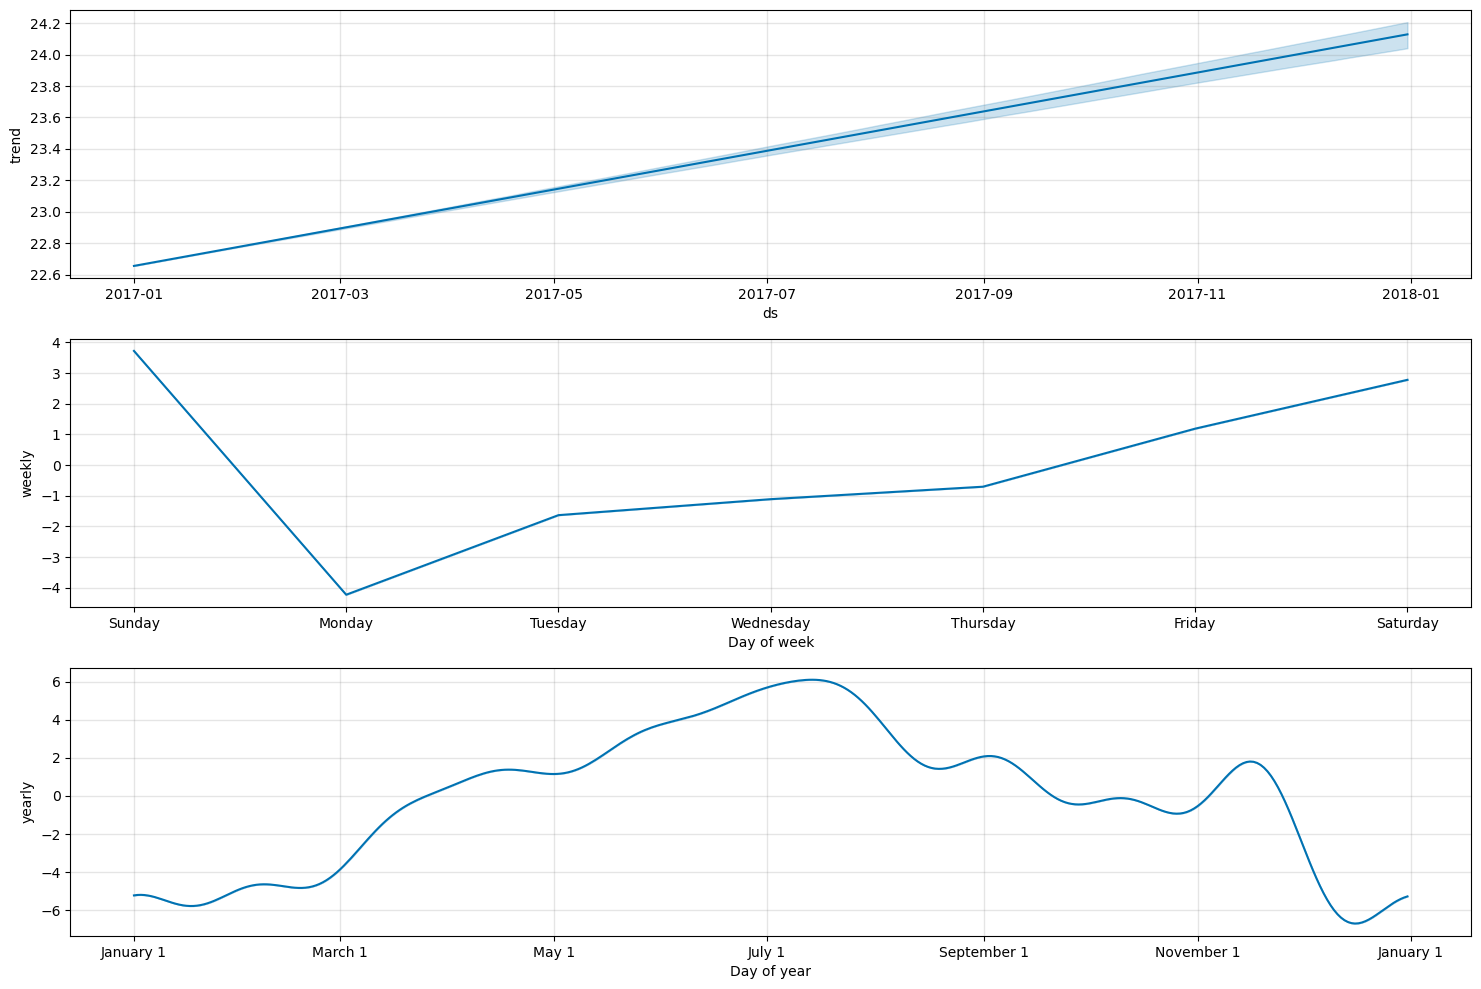

In [13]:
# Преобразовать исходные данные в формат, необходимый для модели Prophet
prophet_train_df = pd.DataFrame(data_train)

# Переименовать столбцы DataFrame: 'y' - целевая переменная, 'ds' - временная метка
prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

# Вывести первые несколько строк DataFrame для проверки
print(prophet_train_df.head())

# Создание модели Prophet с уровнем доверия 95%
prophet_model = Prophet(interval_width=0.95)

# Обучение модели на подготовленных данных
prophet_model.fit(prophet_train_df)

# Создание DataFrame для будущих предсказаний
# periods - количество периодов, на которые нужно сделать предсказание
# include_history=False - исключает исторические данные из предсказания
future = prophet_model.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозирование будущих значений с помощью модели Prophet
y_prophet_forecast = prophet_model.predict(future)

# Вывести первые несколько строк прогноза для проверки
print(y_prophet_forecast.head())

# Визуализация компонентов прогноза
# Модель для каждой даты раскладывает своё предсказание на компоненты (тренд, сезонность и т.д.)
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))

# Отображение графиков
plt.show()

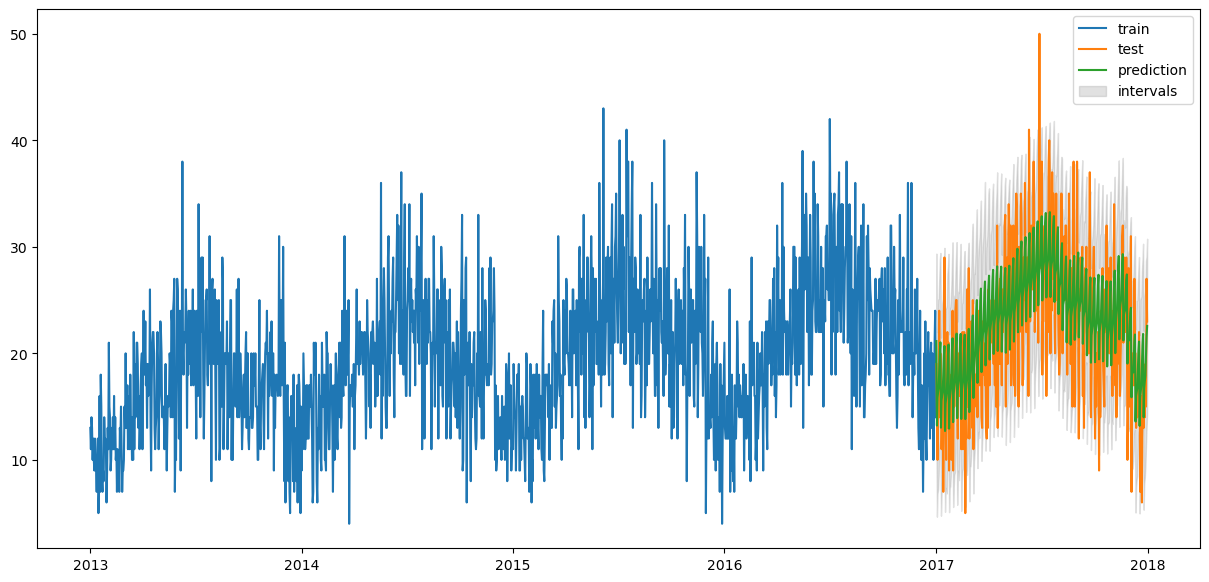

In [14]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [15]:
compare_table = add_method_comparison('Prophet', data_test, y_prophet_forecast['yhat'])
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153


## Что нужно попробовать вам
- Prophet + US holidays.
- Prophet. Преобразование Бокса — Кокса:
    - сделать прямое преобразование над таргетом sps.boxcox(y);
    - потом сделать обратное (нужно написать самим).

## 4.2. Prophet + US holidays

Чтобы добавить праздники США в модель Prophet, вы можете использовать функцию add_seasonality и add_country_holidays. 

             y         ds
date                     
2013-01-01  13 2013-01-01
2013-01-02  11 2013-01-02
2013-01-03  14 2013-01-03
2013-01-04  13 2013-01-04
2013-01-05  10 2013-01-05


15:12:10 - cmdstanpy - INFO - Chain [1] start processing
15:12:11 - cmdstanpy - INFO - Chain [1] done processing


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-01-01  22.663347   13.320249   31.017881    22.663347    22.663347   
1 2017-01-02  22.667451    4.491066   21.760482    22.667451    22.667451   
2 2017-01-03  22.671555    6.703466   24.178296    22.671544    22.671555   
3 2017-01-04  22.675658    7.781333   23.922130    22.675627    22.675679   
4 2017-01-05  22.679762    8.215469   25.075313    22.679699    22.679821   

   Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0            0.0                  0.0                  0.0   
1            0.0                  0.0                  0.0   
2            0.0                  0.0                  0.0   
3            0.0                  0.0                  0.0   
4            0.0                  0.0                  0.0   

   Christmas Day (observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ...  3.717980      3.717980      3.717980   
1               

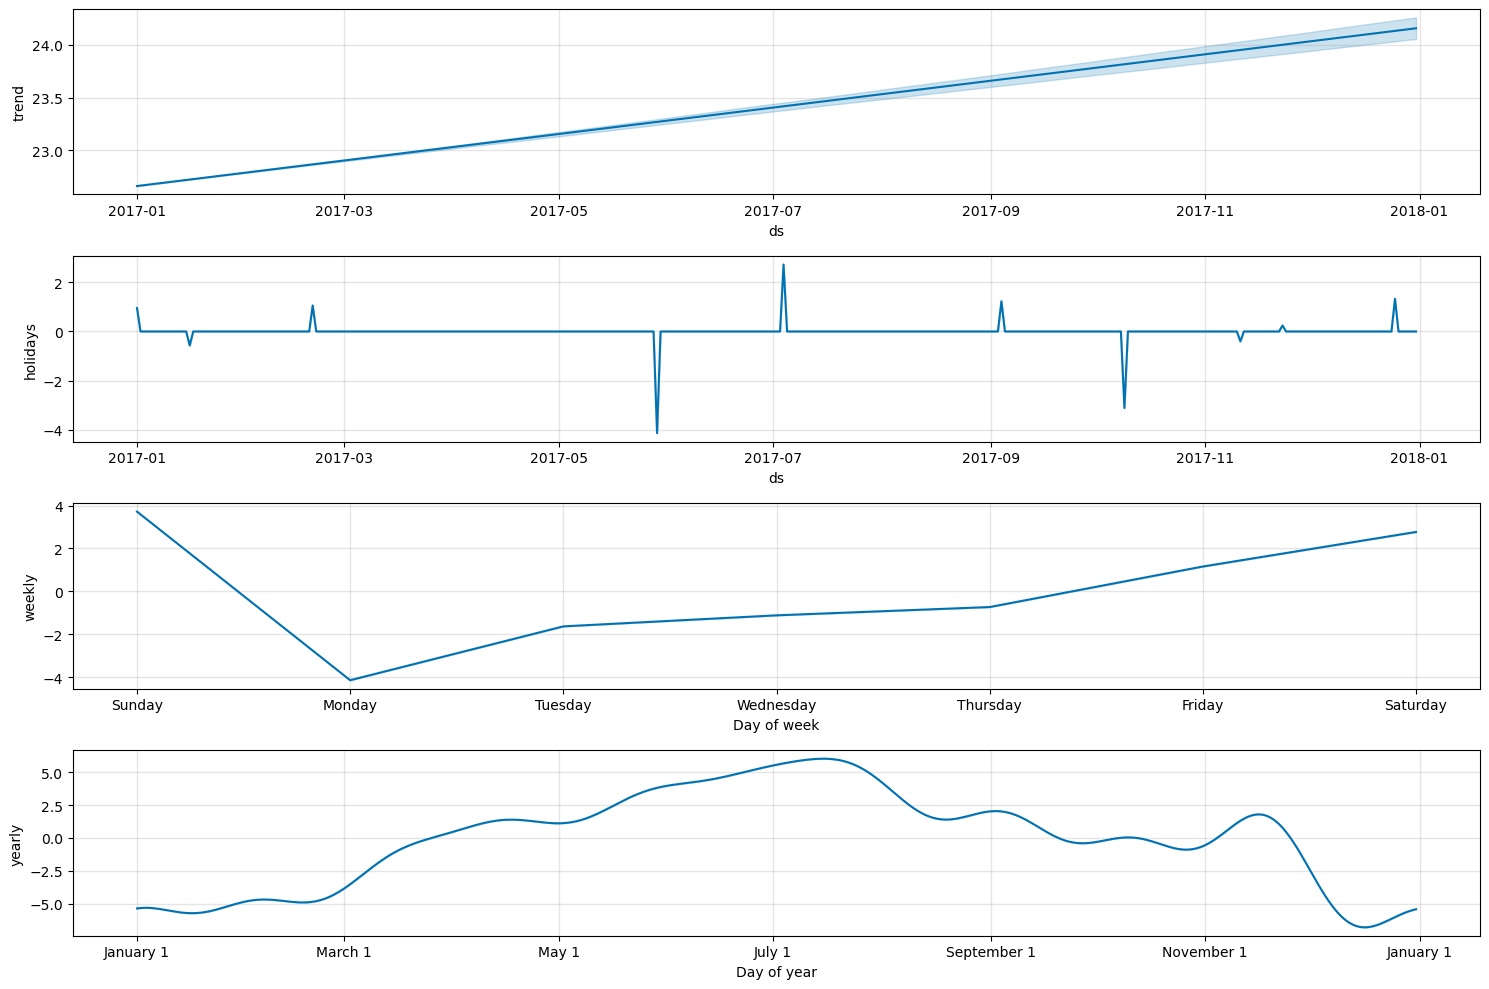

In [16]:


# Предположим, что data_train у вас уже определен и содержит временной ряд
# Пример:
# data_train = pd.Series(index=pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05']), data=[1, 2, 3, 4, 5])

# Преобразовать исходные данные в формат, необходимый для модели Prophet
prophet_train_df = pd.DataFrame(data_train)

# Переименовать столбцы DataFrame: 'y' - целевая переменная, 'ds' - временная метка
prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

# Вывести первые несколько строк DataFrame для проверки
print(prophet_train_df.head())

# Создание DataFrame для праздников
holidays = make_holidays_df(country='US', year_list=[2013, 2014, 2015, 2016, 2017])

# Создание модели Prophet с уровнем доверия 95% и добавлением информации о праздниках
prophet_model_h = Prophet(interval_width=0.95, holidays=holidays)

# Добавление праздников США (если нужно добавить еще какие-то праздники, помимо holidays)
prophet_model_h.add_country_holidays(country_name='US')

# Добавление сезонности в модель Prophet (если необходимы дополнительные сезонности)
# prophet_model_h.add_seasonality(name='US Holidays', period=365.25, fourier_order=10)

'''
years=[2013][2014][2015][2016][2017]: В этом списке перечисляются все годы, для которых нужно создать DataFrame с информацией о праздниках.
Важно включить годы вашей обучающей выборки (2013-2016), чтобы модель могла изучить влияние праздников на временной ряд.
Также я добавил 2017 год, чтобы модель могла использовать данные о праздниках для прогнозирования в тестовом периоде.
'''

# Обучение модели на подготовленных данных
prophet_model_h.fit(prophet_train_df)

# Создание DataFrame для будущих предсказаний
# periods - количество периодов, на которые нужно сделать предсказание
# include_history=False - исключает исторические данные из предсказания
# Предположим, что test_size у вас уже определен, например test_size = 30
future = prophet_model_h.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозирование будущих значений с помощью модели Prophet
y_prophet_forecast_holidays = prophet_model_h.predict(future)

# Вывести первые несколько строк прогноза для проверки
print(y_prophet_forecast_holidays.head())

# Визуализация компонентов прогноза
# Модель для каждой даты раскладывает своё предсказание на компоненты (тренд, сезонность и т.д.)
prophet_model_h.plot_components(y_prophet_forecast_holidays, figsize=(15, 10))

# Отображение графиков
plt.show()


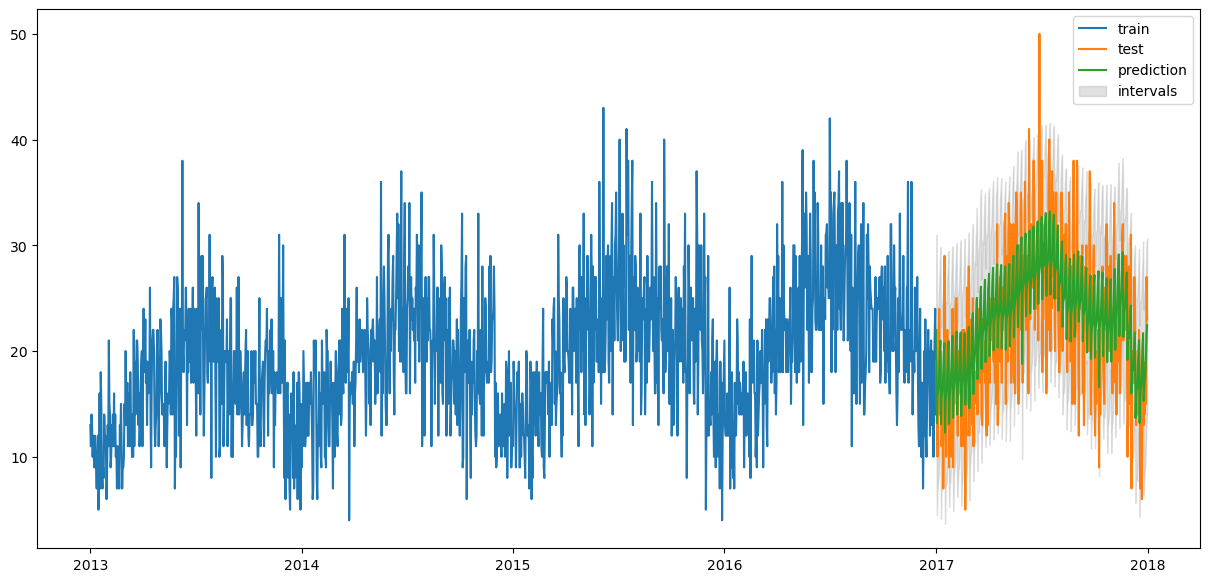

In [17]:
plot_results(data_train, data_test, y_prophet_forecast_holidays['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast_holidays['yhat_lower'],
             right_bound=y_prophet_forecast_holidays['yhat_upper'])

In [18]:
new_experiment = add_method_comparison('Prophet_holidays', data_test, y_prophet_forecast_holidays['yhat'])
# Добавляем новую строку в compare_table
compare_table = compare_table.append(new_experiment, ignore_index=True)
compare_table

/tmp/ipykernel_23828/1980466555.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_table = compare_table.append(new_experiment, ignore_index=True)


,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet_holidays,24.916308,4.058175,22.392373


## 4.3. Prophet. Преобразование Бокса — Кокса

Преобразование Бокса-Кокса — это статистический метод, используемый для стабилизации дисперсии и приведения данных к более близкому соответствию нормальному распределению[2]. Этот метод особенно полезен в регрессионном анализе и других методах статистического моделирования, где предположение о нормальности имеет решающее значение[2].

**Особенности преобразования Бокса-Кокса:**

*   **Стабилизация дисперсии и нормализация:** Основная цель преобразования — сделать дисперсию данных более постоянной и приблизить распределение к нормальному[2]. Это важно, потому что многие статистические методы, такие как регрессионный анализ, предполагают нормальность данных.
*   **Параметр λ (лямбда):** Преобразование Бокса-Кокса включает параметр λ, который определяет тип преобразования, применяемого к данным[2]. Разные значения λ приводят к разным преобразованиям[2]. Например, λ = 0 соответствует логарифмическому преобразованию, а λ = 1 — отсутствию преобразования (тождественное преобразование)[2].
*   **Применимость:** Преобразование Бокса-Кокса определено для положительных данных[2]. Если данные содержат нули или отрицательные значения, необходимо предварительно добавить ко всем значениям константу, чтобы сделать их положительными[3].
*   **Интерпретируемость:** Преобразование Бокса-Кокса может улучшить интерпретируемость результатов за счет уменьшения влияния выбросов и экстремальных значений[2].
*   **Итеративный процесс:** На практике реализация преобразования Бокса-Кокса включает несколько этапов, включая исследование данных, применение преобразования и подбор модели[2]. Аналитики должны визуализировать распределение данных, чтобы оценить степень асимметрии[2]. После этого можно применить преобразование Бокса-Кокса и определить оптимальное значение λ[2].

**Преобразование Бокса-Кокса и Prophet:**

Преобразование Бокса-Кокса может быть полезно при использовании библиотеки Facebook Prophet для прогнозирования временных рядов[4]. Если предсказывать в Prophet не исходный ряд, а ряд после преобразования Бокса-Кокса, нормализующего дисперсию ряда, можно получить прирост качества прогноза[4].

**Преобразования в модели Prophet вместе с преобразованиями Бокса-Кокса:**

В Prophet можно использовать преобразование Бокса-Кокса для стабилизации дисперсии временного ряда перед моделированием[4].  После выполнения прогноза на преобразованных данных необходимо выполнить обратное преобразование Бокса-Кокса, чтобы получить прогнозы в исходном масштабе[6].

Citations:
[1] https://www.youtube.com/watch?v=D3AKcOun29s
[2] https://ru.statisticseasily.com/glossario/what-is-box-cox-transformation/
[3] http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%91%D0%BE%D0%BA%D1%81%D0%B0-%D0%9A%D0%BE%D0%BA%D1%81%D0%B0
[4] https://habr.com/ru/companies/ods/articles/323730/
[5] https://r-analytics.blogspot.com/2015/07/blog-post_19.html
[6] https://habr.com/ru/companies/ods/articles/327242/
[7] https://ranalytics.github.io/tsa-with-r/ch-feature-extraction.html
[8] https://chernobrovov.ru/articles/top-7-python-bibliotek-dlya-vremennyh-ryadov.html

          y         ds
0  5.785460 2013-01-01
1  5.103437 2013-01-02
2  6.109320 2013-01-03
3  5.785460 2013-01-04
4  4.742291 2013-01-05


15:35:44 - cmdstanpy - INFO - Chain [1] start processing
15:35:44 - cmdstanpy - INFO - Chain [1] done processing


          ds      yhat  yhat_original
0 2017-01-01  7.976385      20.379063
1 2017-01-02  5.765854      12.940495
2 2017-01-03  6.524871      15.329875
3 2017-01-04  6.681250      15.843818
4 2017-01-05  6.781437      16.176938


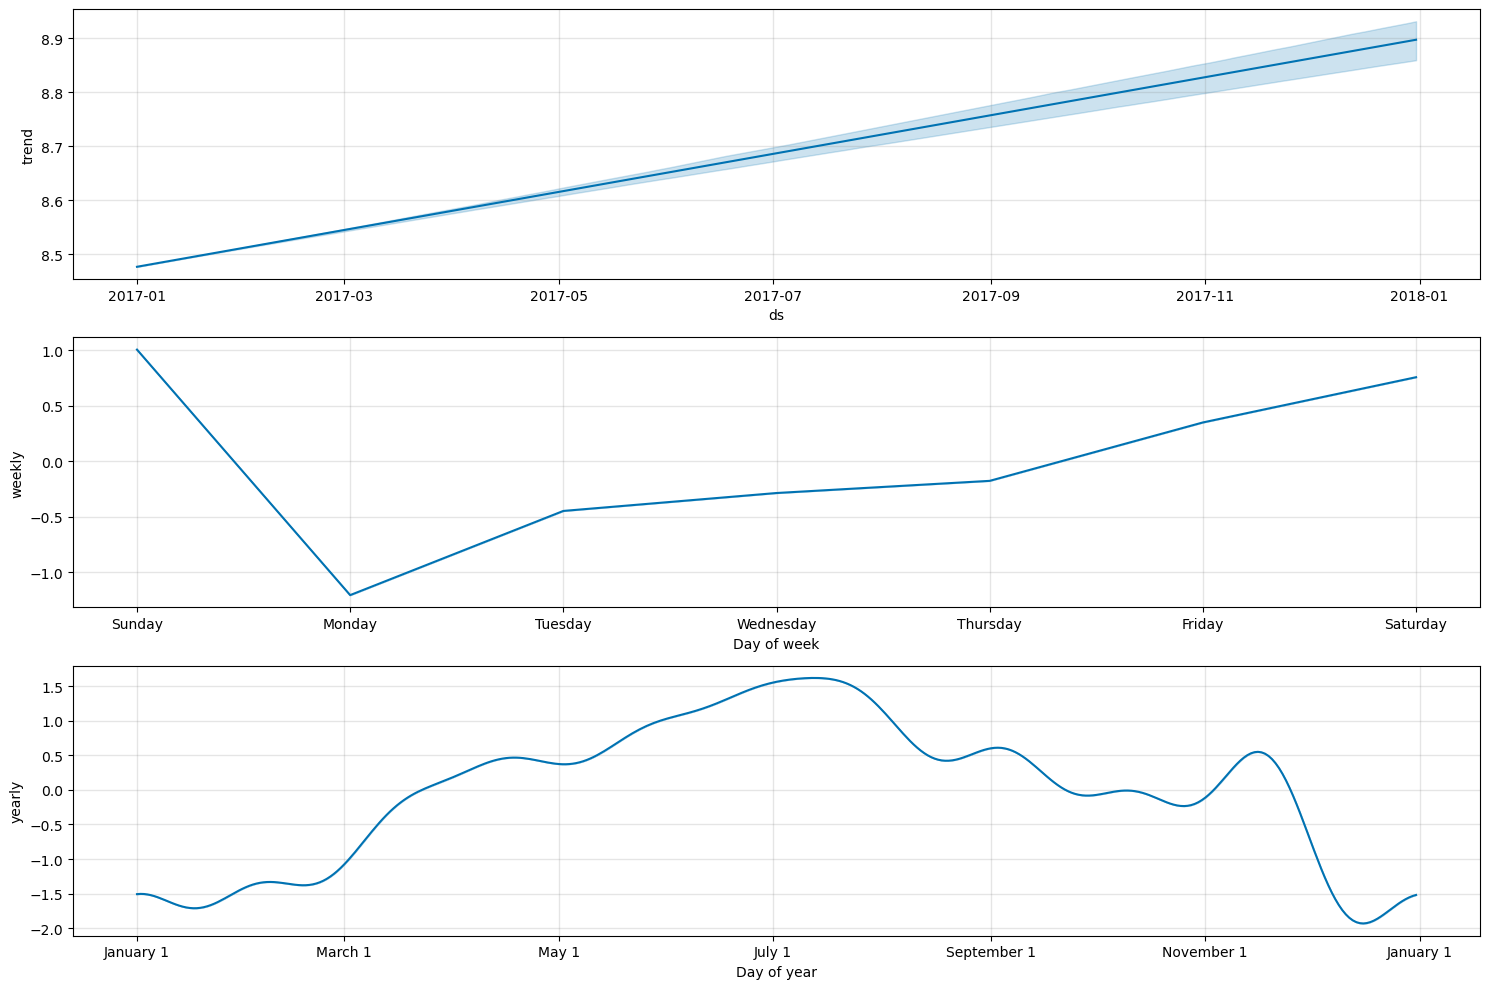

In [24]:
# Преобразование Бокса-Кокса
y = data_train.values  # Извлечение значений целевой переменной
y_boxcox, lambda_ = stats.boxcox(y)  # Прямое преобразование Бокса-Кокса

# Создание DataFrame для Prophet с преобразованными данными
prophet_train_df = pd.DataFrame(y_boxcox, columns=['y'])
prophet_train_df['ds'] = data_train.index  # Используем индексы из оригинального DataFrame

# Вывести первые несколько строк DataFrame для проверки
print(prophet_train_df.head())

# Создание модели Prophet с уровнем доверия 95%
prophet_model_boxcox = Prophet(interval_width=0.95)

# Обучение модели на подготовленных данных
prophet_model_boxcox.fit(prophet_train_df)

# Создание DataFrame для будущих предсказаний
future = prophet_model_boxcox.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозирование будущих значений с помощью модели Prophet
y_prophet_forecast = prophet_model_boxcox.predict(future)

# Обратное преобразование Бокса-Кокса
y_forecast_boxcox = y_prophet_forecast['yhat'].values  # Извлечение предсказанных значений
y_forecast_original = inv_boxcox(y_forecast_boxcox, lambda_)  # Обратное преобразование

# Добавление обратных значений в DataFrame прогноза
y_prophet_forecast['yhat_original'] = y_forecast_original

# Вывести первые несколько строк прогноза для проверки
print(y_prophet_forecast[['ds', 'yhat', 'yhat_original']].head())

# Визуализация компонентов прогноза
prophet_model_boxcox.plot_components(y_prophet_forecast, figsize=(15, 10))

# Отображение графиков
plt.show()


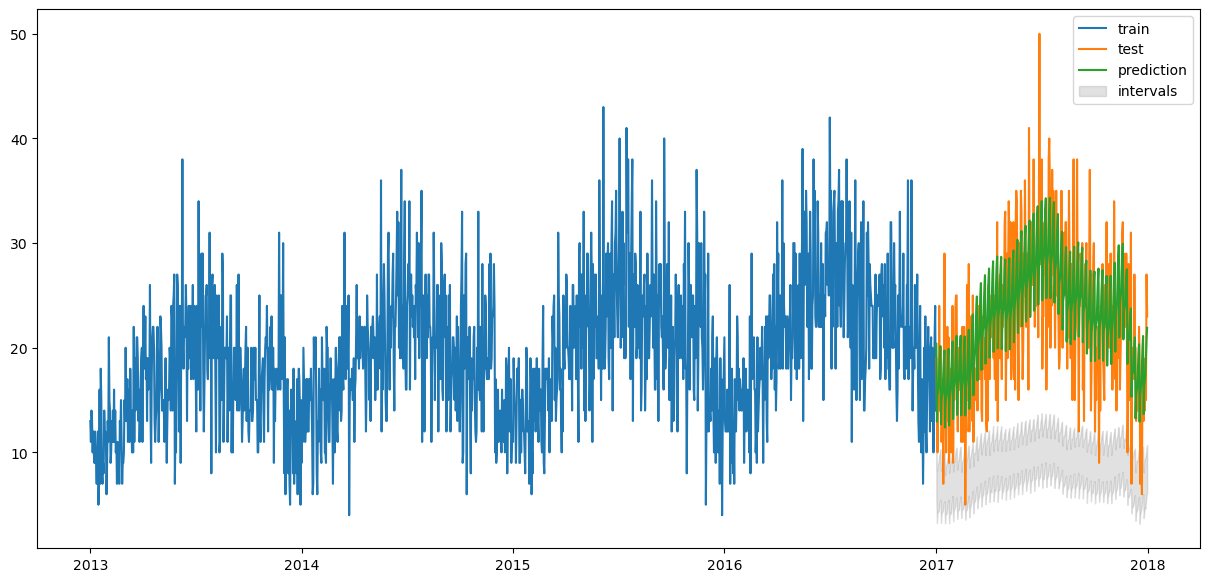

In [43]:
plot_results(data_train, data_test, y_forecast_original, plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [44]:
boxcox_experiment = add_method_comparison('Prophet_boxcox', data_test, y_forecast_original)
# Добавляем новую строку в compare_table
compare_table = compare_table.append(boxcox_experiment, ignore_index=True)
compare_table

/tmp/ipykernel_23828/120321180.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_table = compare_table.append(boxcox_experiment, ignore_index=True)


,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet_holidays,24.916308,4.058175,22.392373
2,Prophet_boxcox,219.189703,13.506985,57.914662
3,Prophet_boxcox,24.172479,3.992453,21.729038
4,Prophet_boxcox,24.172479,3.992453,21.729038


## Добавлена проверка в необходимости boxcox

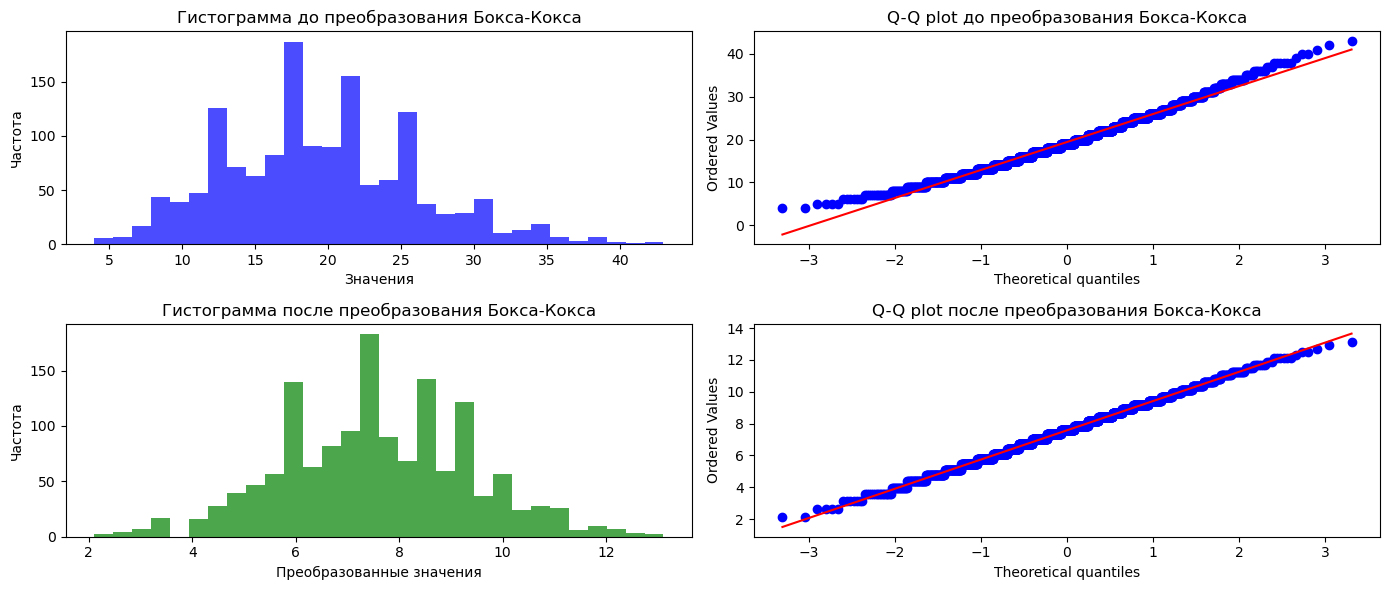

          y         ds
0  5.785460 2013-01-01
1  5.103437 2013-01-02
2  6.109320 2013-01-03
3  5.785460 2013-01-04
4  4.742291 2013-01-05


16:10:41 - cmdstanpy - INFO - Chain [1] start processing
16:10:41 - cmdstanpy - INFO - Chain [1] done processing


          ds      yhat  yhat_original
0 2017-01-01  7.976385      20.379063
1 2017-01-02  5.765854      12.940495
2 2017-01-03  6.524871      15.329875
3 2017-01-04  6.681250      15.843818
4 2017-01-05  6.781437      16.176938


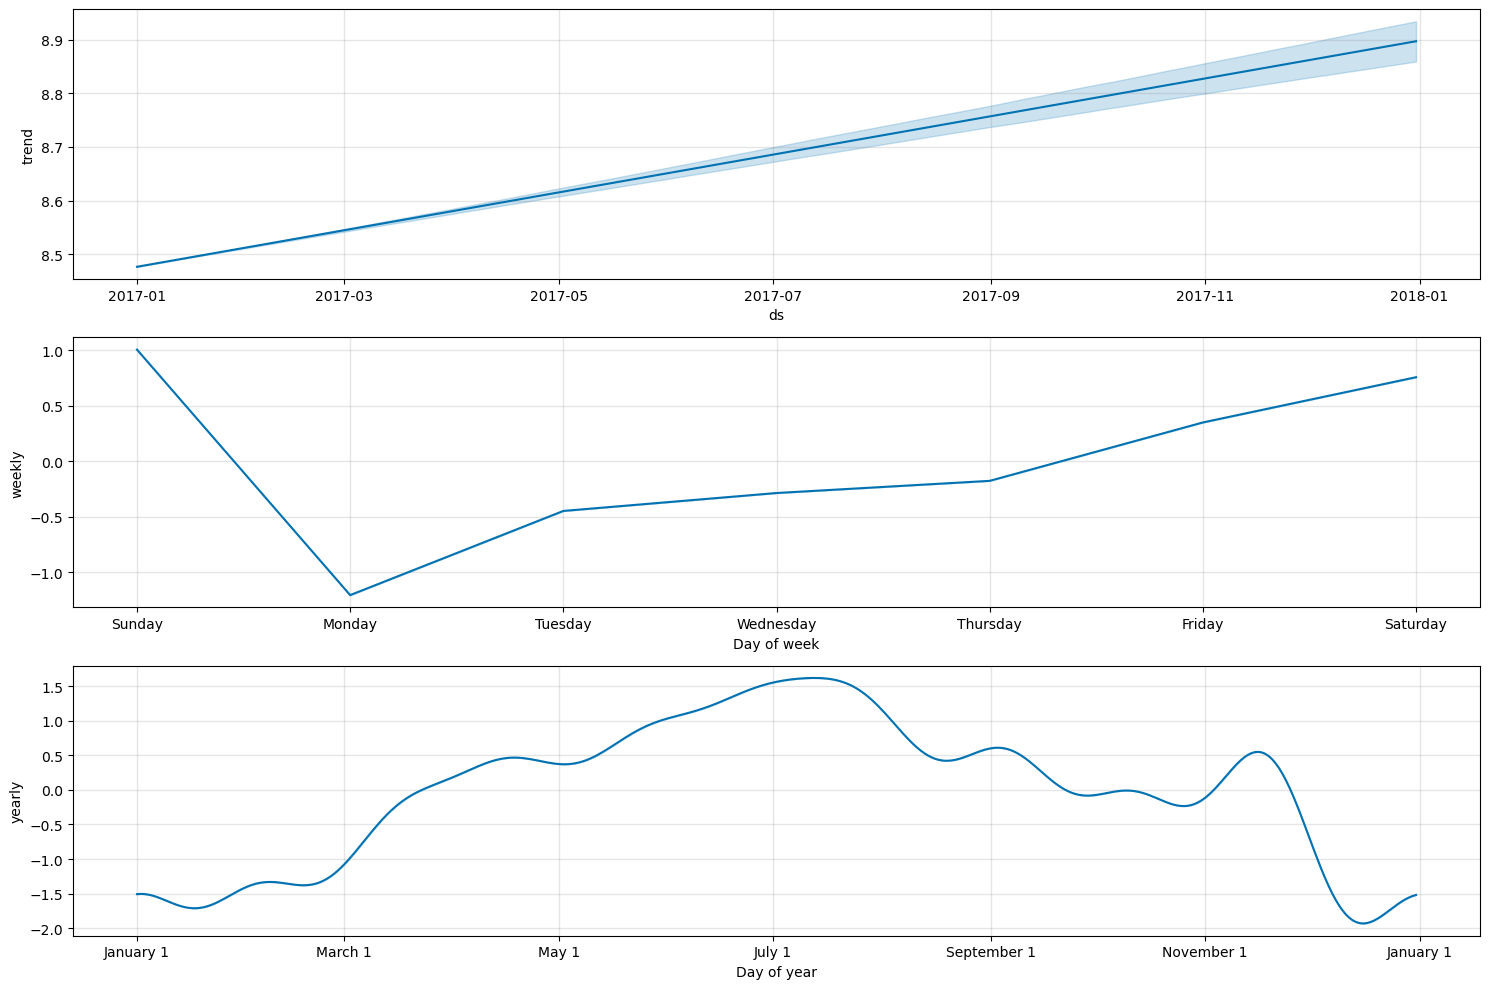

In [41]:


# Преобразование Бокса-Кокса
y = data_train.values  # Извлечение значений целевой переменной
y_boxcox, lambda_ = stats.boxcox(y)  # Прямое преобразование Бокса-Кокса

# Визуализация данных до и после преобразования
plt.figure(figsize=(14, 6))

# Гистограмма до преобразования
plt.subplot(2, 2, 1)
plt.hist(y, bins=30, color='blue', alpha=0.7)
plt.title('Гистограмма до преобразования Бокса-Кокса')
plt.xlabel('Значения')
plt.ylabel('Частота')

# Q-Q plot до преобразования
plt.subplot(2, 2, 2)
probplot(y, dist="norm", plot=plt)
plt.title('Q-Q plot до преобразования Бокса-Кокса')

# Гистограмма после преобразования
plt.subplot(2, 2, 3)
plt.hist(y_boxcox, bins=30, color='green', alpha=0.7)
plt.title('Гистограмма после преобразования Бокса-Кокса')
plt.xlabel('Преобразованные значения')
plt.ylabel('Частота')

# Q-Q plot после преобразования
plt.subplot(2, 2, 4)
probplot(y_boxcox, dist="norm", plot=plt)
plt.title('Q-Q plot после преобразования Бокса-Кокса')

plt.tight_layout()
plt.show()

# Создание DataFrame для Prophet с преобразованными данными
prophet_train_df = pd.DataFrame(y_boxcox, columns=['y'])
prophet_train_df['ds'] = data_train.index  # Используем индексы из оригинального DataFrame

# Вывести первые несколько строк DataFrame для проверки
print(prophet_train_df.head())

# Создание модели Prophet с уровнем доверия 95%
prophet_model_boxcox = Prophet(interval_width=0.95)

# Обучение модели на подготовленных данных
prophet_model_boxcox.fit(prophet_train_df)

# Создание DataFrame для будущих предсказаний
future = prophet_model_boxcox.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозирование будущих значений с помощью модели Prophet
y_prophet_forecast = prophet_model_boxcox.predict(future)

# Обратное преобразование Бокса-Кокса
y_forecast_boxcox = y_prophet_forecast['yhat'].values  # Извлечение предсказанных значений
y_forecast_original = inv_boxcox(y_forecast_boxcox, lambda_)  # Обратное преобразование

# Добавление обратных значений в DataFrame прогноза
y_prophet_forecast['yhat_original'] = y_forecast_original

# Вывести первые несколько строк прогноза для проверки
print(y_prophet_forecast[['ds', 'yhat', 'yhat_original']].head())

# Визуализация компонентов прогноза
prophet_model_boxcox.plot_components(y_prophet_forecast, figsize=(15, 10))


# Отображение графиков
plt.show()

16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing


MSE на тестовых данных: 24.172479462619112


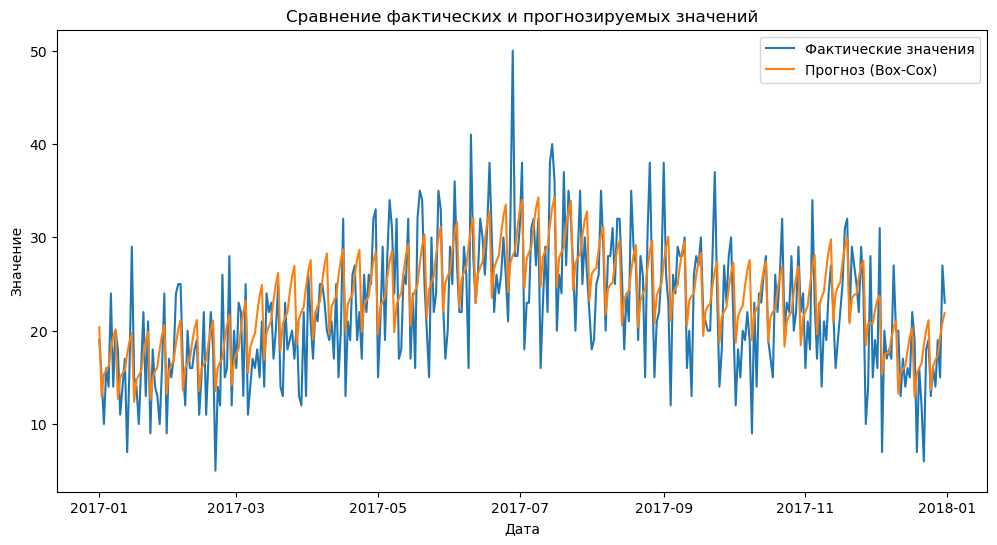

lambda: 0.5667608282343276


In [37]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error  # Import MSE metric

# 1. Подготовка данных (Предположим, data_train и data_test уже определены)
# data_train: pd.Series с временным рядом (индекс - даты)
# data_test: pd.Series с временным рядом (индекс - даты)

# 2. Преобразование Бокса-Кокса (только на обучающих данных!)
y_train = data_train.values
y_train_boxcox, lambda_ = stats.boxcox(y_train)

# 3. Создание DataFrame для Prophet
prophet_train_df = pd.DataFrame({'y': y_train_boxcox, 'ds': data_train.index})

# 4. Создание и обучение модели Prophet
prophet_model_boxcox = Prophet(interval_width=0.95)
prophet_model_boxcox.fit(prophet_train_df)

# 5. Создание DataFrame для прогнозирования (включая тестовый период)
future = prophet_model_boxcox.make_future_dataframe(periods=len(data_test), include_history=True)

# 6. Прогнозирование
forecast = prophet_model_boxcox.predict(future)

# 7. Извлечение прогнозов для тестового периода (после обучения)
y_forecast_boxcox = forecast['yhat'][-len(data_test):].values

# 8. Обратное преобразование Бокса-Кокса
y_forecast_original = inv_boxcox(y_forecast_boxcox, lambda_)

# 9. Оценка MSE на тестовых данных в исходном масштабе
mse = mean_squared_error(data_test.values, y_forecast_original)
print(f'MSE на тестовых данных: {mse}')

# 10. Визуализация (по желанию)
# Сравнение фактических и прогнозируемых значений на графике
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test.values, label='Фактические значения')
plt.plot(data_test.index, y_forecast_original, label='Прогноз (Box-Cox)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Сравнение фактических и прогнозируемых значений')
plt.legend()
plt.show()

# 11. Проверка lambda
print(f"lambda: {lambda_}")


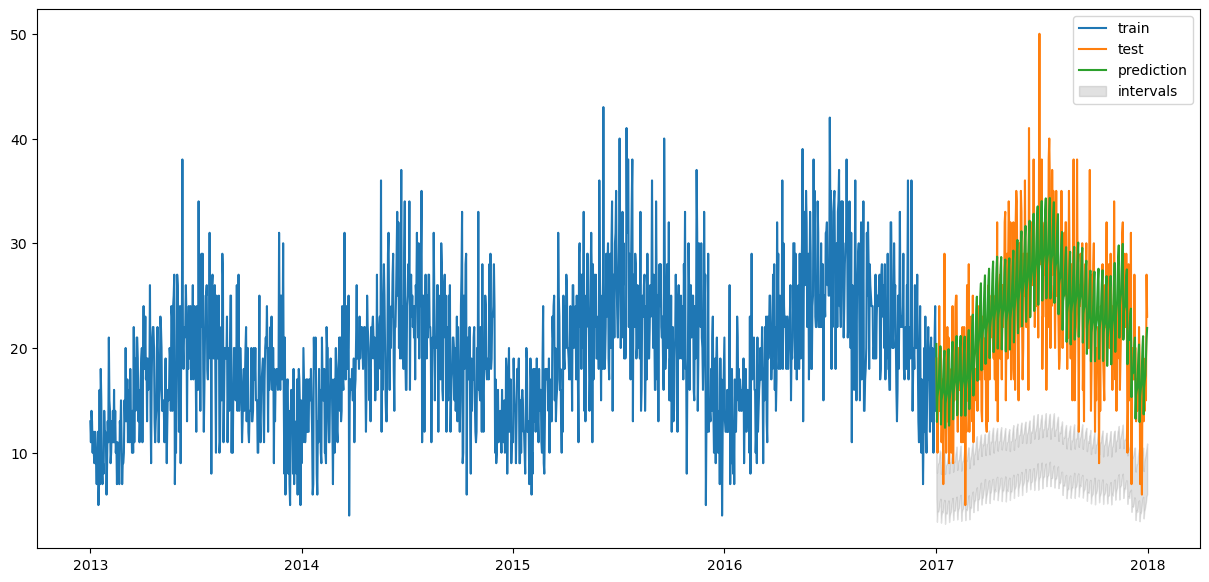

In [ ]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

## improve boxcox

In [ ]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:29:56 - cmdstanpy - INFO - Chain [1] done processing


MSE на тестовых данных: 24.172479462619112


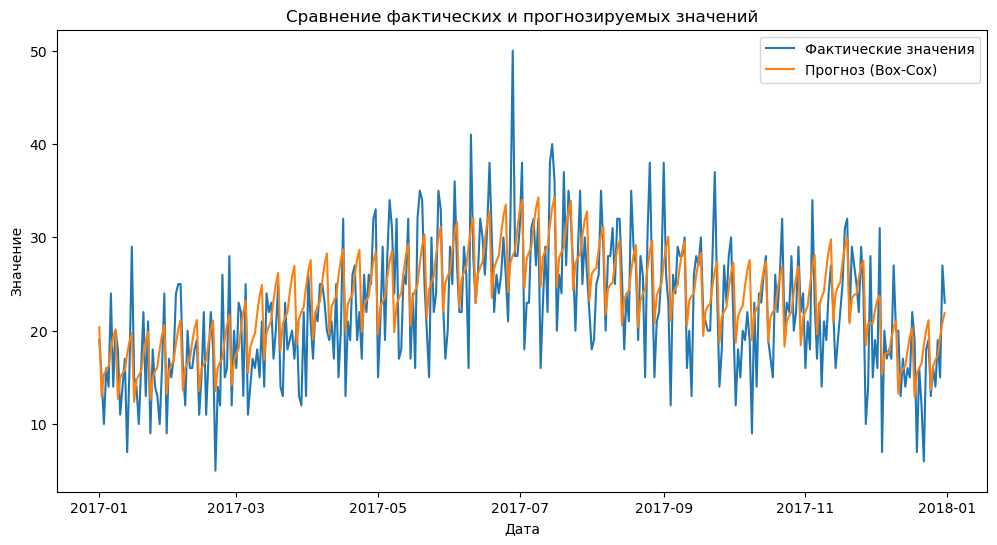

In [47]:


# 3. Преобразование Бокса-Кокса (только на обучающих данных!)
y_train = data_train.values
y_train_boxcox, lambda_ = stats.boxcox(y_train)

# 4. Создание DataFrame для Prophet
prophet_train_df = pd.DataFrame({'y': y_train_boxcox, 'ds': data_train.index})

# 5. Создание и обучение модели Prophet
prophet_model_boxcox = Prophet(interval_width=0.95)
prophet_model_boxcox.fit(prophet_train_df)

# 6. Создание DataFrame для прогнозирования (включая тестовый период)
# Создаем DataFrame с будущими датами для прогнозирования
future = prophet_model_boxcox.make_future_dataframe(periods=len(data_test), include_history=True)

# 7. Прогнозирование
forecast = prophet_model_boxcox.predict(future)

# 8. Извлечение прогнозов для тестового периода
y_forecast_boxcox = forecast['yhat'][-len(data_test):].values

# 9. Обратное преобразование Бокса-Кокса
y_forecast_original = inv_boxcox(y_forecast_boxcox, lambda_)

# 10. Оценка MSE на тестовых данных в исходном масштабе
mse = mean_squared_error(data_test.values, y_forecast_original)
print(f'MSE на тестовых данных: {mse}')

# 11. Визуализация (по желанию)
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test.values, label='Фактические значения')
plt.plot(data_test.index, y_forecast_original, label='Прогноз (Box-Cox)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Сравнение фактических и прогнозируемых значений')
plt.legend()
plt.show()


## 5. AutoARIMA [without exog]

In [45]:
arima_model = auto_arima(data_train, seasonal=True, m = 7)

KeyboardInterrupt: 

In [ ]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

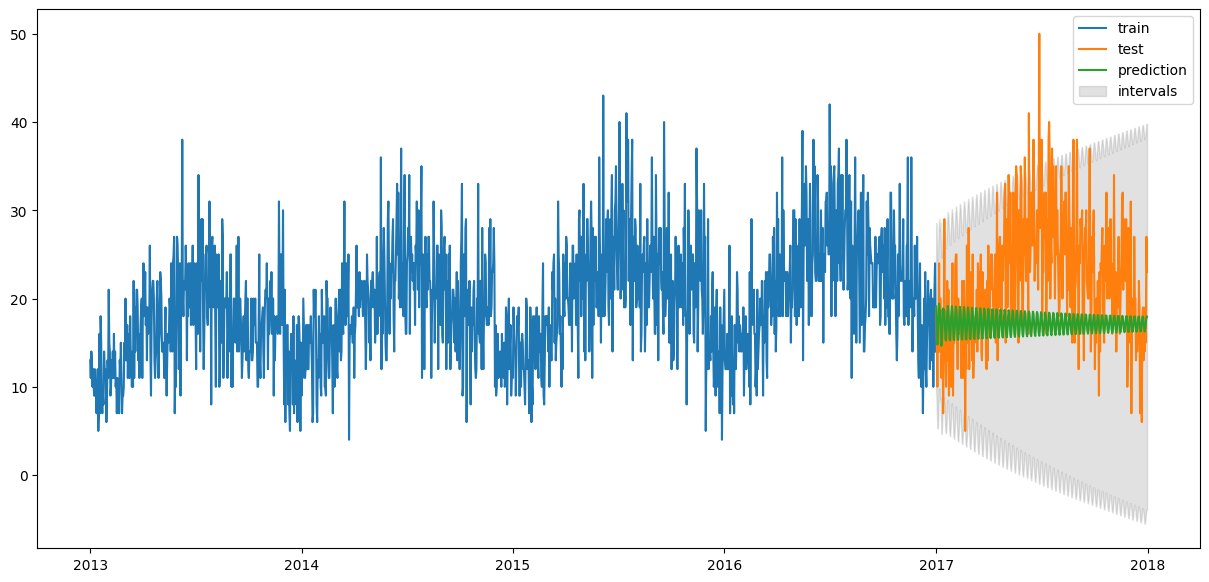

In [ ]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

In [ ]:
compare_table = add_method_comparison('Auto arima model', data_test, y_arima_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200


### 6. AutoARIMA exog

In [ ]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: используйте модель `auto_arima` с экзогенными переменными, которые созданы выше (их не надо менять).

### 7.1. SARIMAX [without exog]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    ).fit()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04153D+00    |proj g|=  9.03353D-02

At iterate    5    f=  3.03248D+00    |proj g|=  2.12893D-02

At iterate   10    f=  3.03083D+00    |proj g|=  1.68000D-03

At iterate   15    f=  3.02982D+00    |proj g|=  5.12593D-02

At iterate   20    f=  3.02735D+00    |proj g|=  5.36306D-03



At iterate   25    f=  3.02555D+00    |proj g|=  6.73030D-02

At iterate   30    f=  3.01767D+00    |proj g|=  3.79465D-02

At iterate   35    f=  3.01183D+00    |proj g|=  3.85218D-01

At iterate   40    f=  3.00163D+00    |proj g|=  1.84942D-01

At iterate   45    f=  2.99775D+00    |proj g|=  1.91284D-01


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.99563D+00    |proj g|=  3.50949D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     75      1     0     0   3.509D-01   2.996D+00
  F =   2.9956281574795196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
forecast = real_sarimax_model.get_forecast(steps=len(data_test))
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


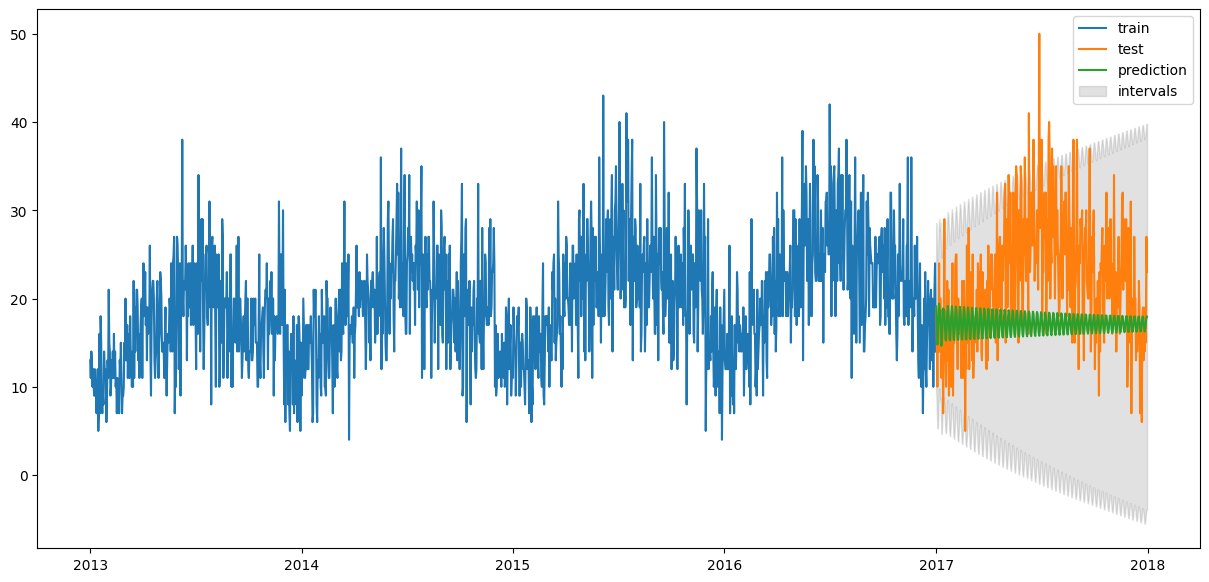

In [ ]:
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])

In [ ]:
compare_table = add_method_comparison('Original SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200


### 7.2. SARIMAX with exog

In [ ]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: для улучшения предсказаний используйте модель `SARIMAX` с экзогенными переменными, которые созданы выше (их не надо менять).

### 8. TBATS

Модель учитывает несколько сезонностей, но не может принимать экзогенные признаки.

In [ ]:
tbats_estimator = TBATS(seasonal_periods=(7,180))
model = tbats_estimator.fit(data_train)

In [ ]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 180.]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.099254
Seasonal Parameters (Gamma): [ 0.00073066  0.00126936 -0.00168366 -0.00071583]
AR coefficients []
MA coefficients []
Seed vector [11.64783078 -2.63361686 -0.19728629  1.19371923 -0.73577877  1.77368199
  0.93247816  0.28014787 -0.22456824 -0.7175311  -0.93148604 -0.02311377
  0.1540708 ]

AIC 15098.062708


In [ ]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

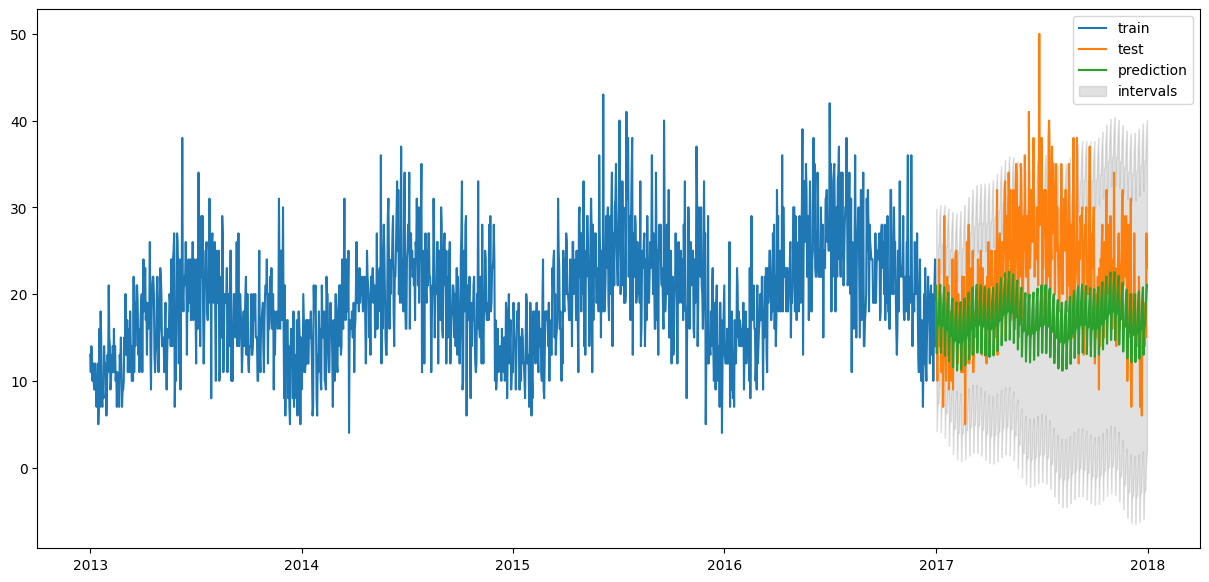

In [ ]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

In [ ]:
final_table = add_method_comparison('TBATS model', data_test, tbats_forecast, compare_table)

In [ ]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200
3,TBATS model,64.837640,6.335522,27.126855


### 9. Итого

todo:
- Опишите, что вы сделали в данной работе, какие параметры моделей подбирали и как.
- Сравните модели между собой и проанализируйте результаты.
- Выберите лучшую модель.

Метрика MAPE, которой можно достичь (достаточно правильной настройки гиперпараметров моделей), — менее 20%.

In [ ]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200
3,TBATS model,64.837640,6.335522,27.126855
